# Titanic - Machine Learning from Disaster, Kaggle Competition
### Lian Martin

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we are asked to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Methodology

This section will outline my methodology throughout the project.

1.	Exploratory Data Analysis
- Understand the data to see what features we have
- Descriptive statistics regarding data shape, distribution of our target variable, etc.
- Explore our features

2. Data Preparation
- Clean the data based on results from EDA
- Feature engineering as applicable
- Transform data using a Box-Cox Power Transformation
- Split data into train and test sets

3. Model Training
- Fit an initial model and evaluate to see what we can expect from a baseline model
- Tune hyper parameters
- Five fold cross validation

4.	Final model selection and evaluation on test set 
- Select the best model based on the training set performance and evaluate it on the test set to get an unbiased view on how the model will perform on completely unseen data

## Exploratory Data Analysis

Using the Titanic dataset from [this](https://www.kaggle.com/competitions/titanic) Kaggle competition, we are given a training and testing data set in csv format. 

Training: Our training data consists of 891 passengers onboard the Titanic with 11 features describing each passenger's demographic information. We are given a binary variable 'Survived' (label) indicating whether that passenger survived. The training data is what we will use to “teach” our models.

Testing: The test data set consists of 418 examples with the same features as the training data. Our test data set excludes the 'Survived' column because this is what we are trying to predict.

### Data Dictionary

Here is a brief version of what you'll find in the data description (taken from Kaggle). To find more information, you can reference [this](https://www.kaggle.com/competitions/titanic/data) page on Kaggle.

- **Survived** : Survival, 0 = No, 1 = Yes
- **Pclass** : The ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd
- **Sex**: Sex
- **Age**: Age in years
- **Sibsp**: Number of siblings/spouses aboard the Titanic
- **Parch**: Number of parents/children aboard the titanic
- **Ticket**: Ticket number
- **Fare**: Passenger fare
- **Cabin**: Cabin number
- **Embarked**: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southhampton

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import scipy.stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestClassifier #for model
from sklearn.model_selection import GridSearchCV #allows you to search for best settings

In [65]:
#Read in our data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [66]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [67]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


As stated, we have 11 features in our dataset to help us predict whether that passenger survived the Titanic or not. Let's begin with some descriptive statistic work.

### Descriptive Statistics

In [68]:
#Check the number of rows and columns in the data
print('The train set has size (row, column): ', train.shape)
print('The test set has size (row, column): ', test.shape)

The train set has size (row, column):  (891, 12)
The test set has size (row, column):  (418, 11)


In [69]:
#Check for missing values in train
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [70]:
#Check for missing values in test
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Note About NaN Values

Train: Cabin, Age, Embarked features contain a number of null values which will require correcting

Test: Cabin, Age are incomplete 

In [71]:
#Check the type of each variable
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Distribution of Our Target Variable

In [72]:
#Check the distribution of our target variable
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Our distribution is not perfectly equal, but we do not necessarily have a class imbalance, so no further adjustments. This is an important step in understanding the data we are presented with. If we had a class imbalance, the model could be biased.

At this point, it is also important to note that our dataset has a 38% survival rate. In contrast, the official Titanic survival rate sits at 32%.

### Categorical Features

This section will focus our analysis on categorical features, `Name`, `Sex`, `Ticket`, `Cabin`, and `Embarked` features.

Note: Name by itself is not a categorical feature. Taking an initial look at the data, we can feature engineer name into a `Title` feature.

In [73]:
cat = pd.read_csv('train.csv', usecols = ['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'])
cat.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [74]:
#Explore the number of unique values for each feature
for col in cat.columns:
    print('{}: {} unique values'.format(col, cat[col].nunique()))
    
#We will group similar # of unique values (Sex, embarked) vs (name, ticket, cabin)

Survived: 2 unique values
Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values


### Visualizations Based on Survival -  Sex and Embarked

In [75]:
#Create died column

train['Died'] = 1-train['Survived']

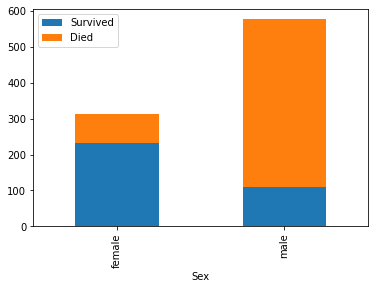

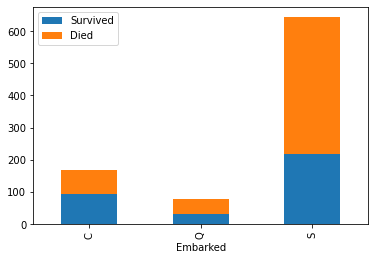

In [76]:
#Sex and Embarked

feat = ['Sex', 'Embarked']

for i in feat:
    train.groupby(i).agg('sum')[['Survived', 'Died']].plot(kind = 'bar', stacked = True)

For our two categorical features visualized above, we see that females have a higher chance of survival and embarking from Cherbourg has a higher chance of survival. This may not be causal, but it could perhaps provide us with some information about socio-economic status. Cherbourg could be a wealthier area, which could relate to socio-economic status. We will have to explore continuous features, Fare and Pclass, to test this assumption.

### Name, Ticket, Cabin

To begin with, we will be feature engineering the `Name` column into `Title` column. In addition, Cabin seems to have lots of missing values that we need to explore. First, we will have to determine whether cabin is missing at random or not.

In [77]:
#Is Cabin missing at random?

cat.groupby(train['Cabin'].isnull()).mean() # group by whether cabin is missing and tell us what % in each group survived

,Survived
Cabin,
False,0.666667
True,0.299854


We just found that approximately 2/3 of passengers without a cabin did not survive. This could mean something. Whether a cabin is missing could be a strong indicator of whether a passenger survived or not. Perhaps not having a cabin documented means that the passenger truly did not have a cabin, and therefore, did not have as many resources to survive. We could feature engineer this feature to illustrate this.

In [78]:
#Unique values for the Ticket feature
cat['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Ticket appears to be assigned at random, most likely will drop.

### Explore Continuous Features
This section focuses on exploring the `Pclass`, `Age`, `SibSp`, `Parch`, and `Fare` features.

In [79]:
cont = pd.read_csv('train.csv', usecols = ['Survived','Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
cont.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


### Descriptive Statistics

In [80]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.616162
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [81]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.005007
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-1.000000
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.338481
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.077221
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.035322
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.081629
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.257307
Died,0.005007,-1.000000,0.338481,0.077221,0.035322,-0.081629,-0.257307,1.000000


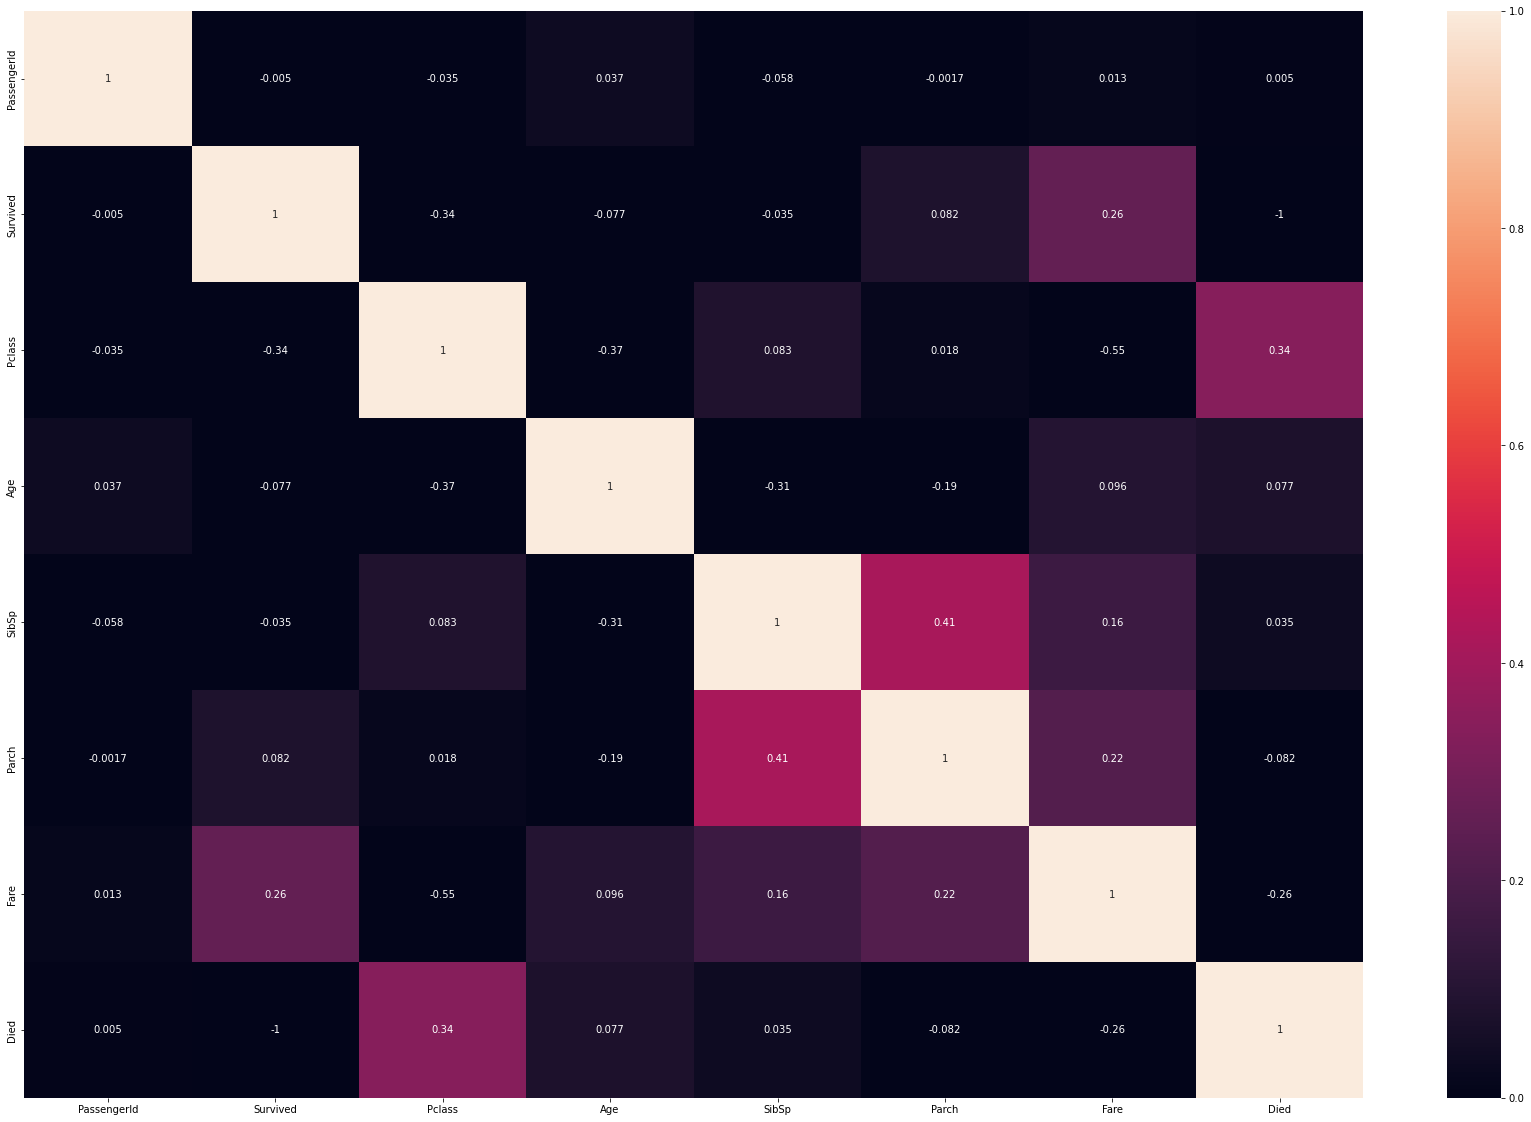

In [82]:
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(train.corr(), vmin=0, vmax=1, annot=True)

Taking a look at our correlation matrix, we see that Pclass and Fare have the largest correlation with whether a passenger survived or not. However, these two features are also highly correlated with each other. We will have to do some further EDA.

### Pclass and Fare

<AxesSubplot:xlabel='Pclass'>

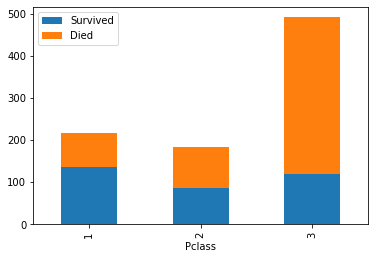

In [83]:
train.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind = 'bar', stacked = True)

#We see that being in first class increases a passenger's chances of surviving

In [84]:
#Dig into Pclass vs Fare
#Look at fare by different passenger class levels
train.groupby('Pclass')['Fare'].describe() 

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


When we group by Pclass by describing Fare, we see barely any overlap in interquartile ranges. 75% for 3rd class is barely higher than 25% for 2nd class. 75% for 2nd class is not even higher than 25 for 1st class. If we have a strong correlation between the two, we could confuse the model. However, we will never know how the model will react without actually trying it.

### Visualize Survial Based on Fare

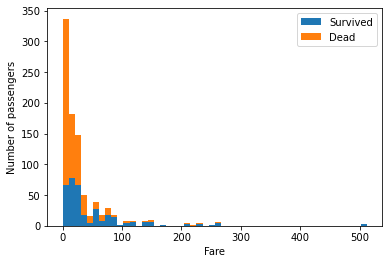

In [85]:
figure = plt.figure()
plt.hist([train[train['Survived'] == 1]['Fare'], train[train['Survived'] == 0]['Fare']], 
         stacked=True, bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

In addition to Pclass and Embarked, we see that passengers with a higher fare price are more likely to survive than passengers that paid a low fare price. It seems that socio-economic status may have played a large factor in survival rate.

### SibSp and Parch

In [86]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SibSp', ylabel='count'>

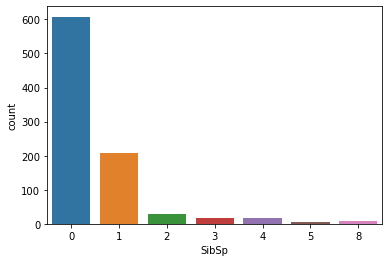

In [87]:
sns.countplot('SibSp', data=train)

In [88]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Parch', ylabel='count'>

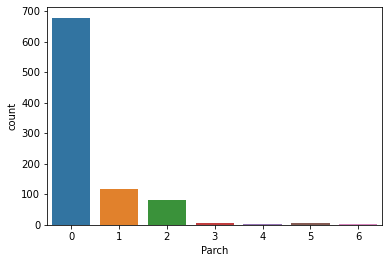

In [89]:
sns.countplot('Parch', data = train)

This data looks really similar. Let's explore the statistics further.

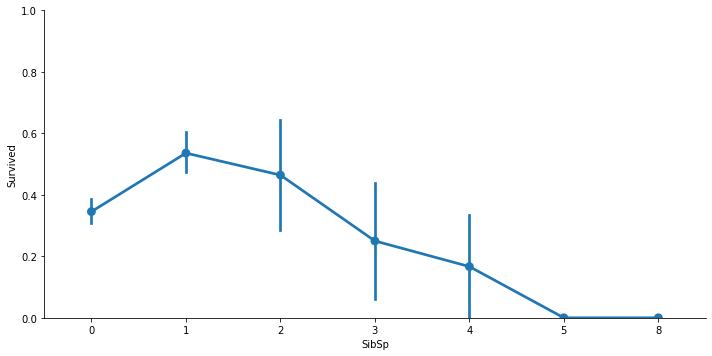

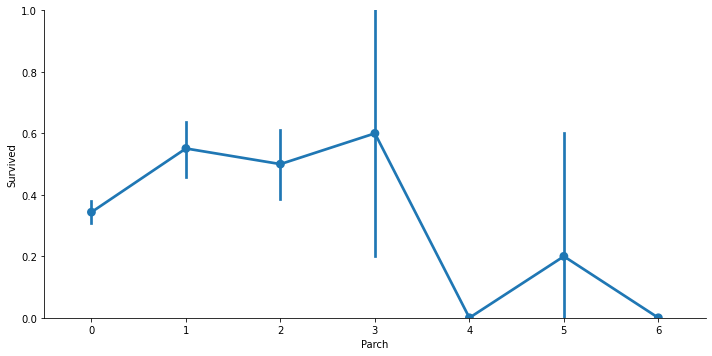

In [90]:
#Generate categorical plots for ordinal features
col = ['SibSp', 'Parch']

for i in col:
    sns.catplot(x=i, y='Survived', data=train, kind='point', aspect=2, )
    plt.ylim(0, 1)

We see the same patterns in siblings aboard and parents aboard, we can combine these categorical features. Although we have found trends, we can never know until we test.

### Summary of EDA

- **Name** : by itself not very helpful, use feature engineering and use title instead of name
- **Sex**: females seem to have a better chance of survival than males, sex will likely be correlated with title
- **Cabin**: missing for more than 75% of passengers, uncovered a strong correlation with survival of whether a cabin was missing or not
- **Embarked**: likely not causual, but correlated with cabin and possibly socio-economic status
- **Ticket**: random, no signal
- **SibSp and Parch**: feature engineering to combine SibSp and Parch to create a variable FamCount
- **Fare and Pclass**: Fare is likely correlated with Pclass, might be worth exploring only one of the features instead of both


Overall, we have learned that title, cabin, and sex have a high correlation with survival

## Data Preparation

### Feature Engineering

In [28]:
#Concatenate dataframes for cleaning

train_test = pd.concat([train, test], axis=0)
train_test

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


#### Name -> Title

In [30]:
#Many names have title which can contribute bc of status
#Create a title feature by parsing passenger name
train_test['Title'] = train_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
#train_test

In [31]:
#Survival rate by title

#train['Title'].value_counts()

train_test.pivot_table('Survived', index=['Title', 'Sex'], aggfunc=['count', 'mean'])

#Master = primarily male and they survive at a 57% rate

count      mean
                    Survived  Survived
Title        Sex                      
Capt         male          1  0.000000
Col          male          2  0.500000
Don          male          1  0.000000
Dona         female        0       NaN
Dr           female        1  1.000000
             male          6  0.333333
Jonkheer     male          1  0.000000
Lady         female        1  1.000000
Major        male          2  0.500000
Master       male         40  0.575000
Miss         female      182  0.697802
Mlle         female        2  1.000000
Mme          female        1  1.000000
Mr           male        517  0.156673
Mrs          female      125  0.792000
Ms           female        1  1.000000
Rev          male          6  0.000000
Sir          male          1  1.000000
the Countess female        1  1.000000

#### Cabin -> CabinMissing

Create a CabinMissing indicator feature where 0 = NaN and 1 = the passenger was assigned a cabin

In [32]:
train_test['CabinMissing'] = train_test['Cabin'].notnull().astype('int')
#train_test

#### FamCount

In [34]:
train_test['FamCount'] = train_test['SibSp'] + train_test['Parch']
#train_test

### Cleaning Train and Test Dataset

In [35]:
#Address nan columns
train_test.isnull().sum()

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin           1014
Embarked           2
Died             418
Title              0
CabinMissing       0
FamCount           0
dtype: int64

In [36]:
#Find median age for men and women respectively
median_age_male = train_test[train_test['Sex']=='male']['Age'].median()
median_age_female = train_test[train_test['Sex'] == 'female']['Age'].median()

In [37]:
#Replace NaN values in 'Age' with median age based on gender

train_test.loc[(train_test.Age.isnull()) & (train_test['Sex'] == 'male'),'Age'] = median_age_male
train_test.loc[(train_test.Age.isnull()) & (train_test['Sex'] == 'female'),'Age'] = median_age_female
#train_test
#train_test.isnull().sum()

In [38]:
#Fill missing fare with median fare
train_test['Fare'] = train_test['Fare'].fillna(train_test['Fare'].median())
#Train_test.isnull().sum()

In [39]:
#Fill missing embarked with 0

train_test['Embarked'] = train_test['Embarked'].fillna('O')
train_test.isnull().sum()

PassengerId        0
Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin           1014
Embarked           0
Died             418
Title              0
CabinMissing       0
FamCount           0
dtype: int64

In [40]:
#Drop unneccessary columns

train_test = train_test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Died'])
train_test

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount
0,1,0.0,3,male,22.0,7.2500,S,Mr,0,1
1,2,1.0,1,female,38.0,71.2833,C,Mrs,1,1
2,3,1.0,3,female,26.0,7.9250,S,Miss,0,0
3,4,1.0,1,female,35.0,53.1000,S,Mrs,1,1
4,5,0.0,3,male,35.0,8.0500,S,Mr,0,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,28.0,8.0500,S,Mr,0,0
414,1306,NaN,1,female,39.0,108.9000,C,Dona,1,0
415,1307,NaN,3,male,38.5,7.2500,S,Mr,0,0
416,1308,NaN,3,male,28.0,8.0500,S,Mr,0,0


In [41]:
#Convert categorical feature to numeric

for feature in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    train_test[feature] = le.fit_transform(train_test[feature].astype(str)) # ex. map male to 1 and female to 0
    
train_test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount
0,1,0.0,3,1,22.0,7.2500,3,12,0,1
1,2,1.0,1,0,38.0,71.2833,0,13,1,1
2,3,1.0,3,0,26.0,7.9250,3,9,0,0
3,4,1.0,1,0,35.0,53.1000,3,13,1,1
4,5,0.0,3,1,35.0,8.0500,3,12,0,0


In [42]:
#Verify that we do not have any NaN values
train_test.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Sex               0
Age               0
Fare              0
Embarked          0
Title             0
CabinMissing      0
FamCount          0
dtype: int64

### Data Transformation

/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


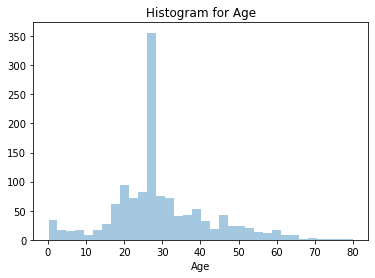

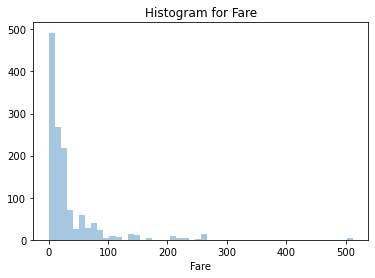

In [43]:
#Plot histogram for each continuous feature to see if a transformation is necessary
for feature in ['Age', 'Fare']:
    sns.distplot(train_test[feature], kde=False)
    plt.title('Histogram for {}'.format(feature))
    plt.show()

- Age is pretty well behaved
- Fare is well behaved below 40, but long tail larger than 40

### Box-Cox Power Transformation

/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/lianmartin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is 

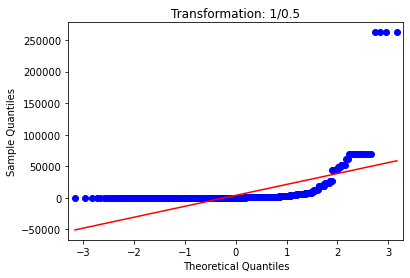

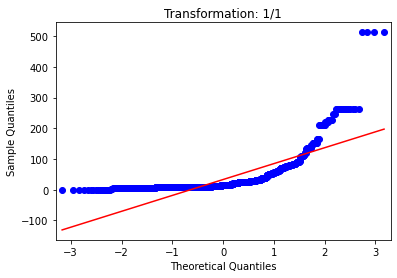

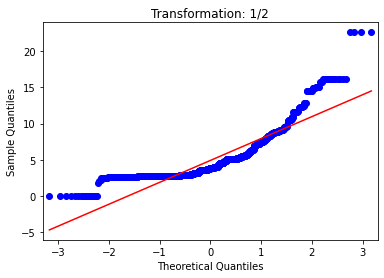

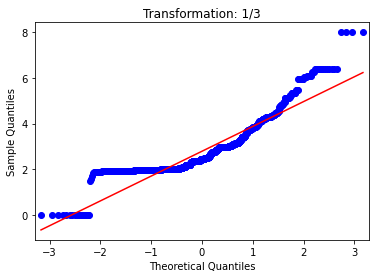

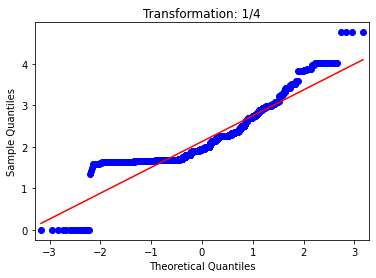

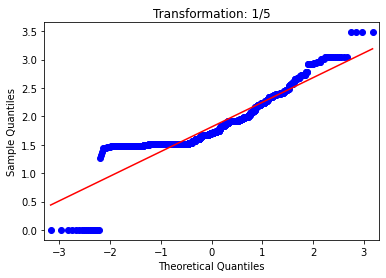

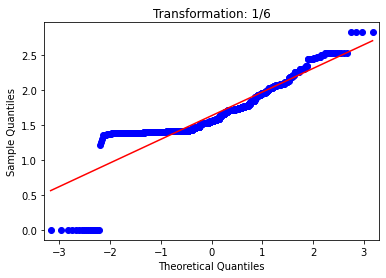

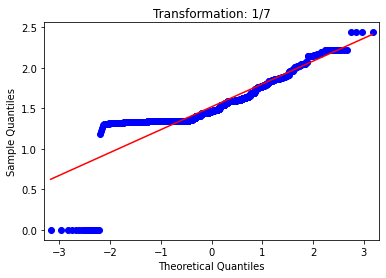

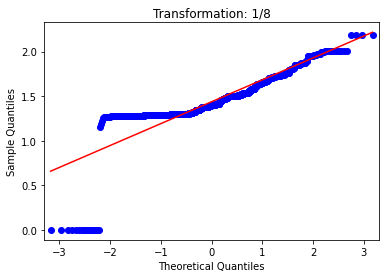

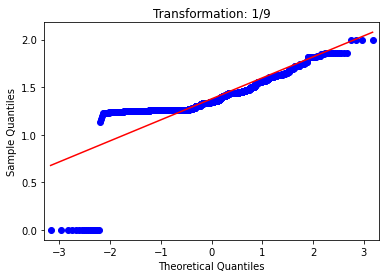

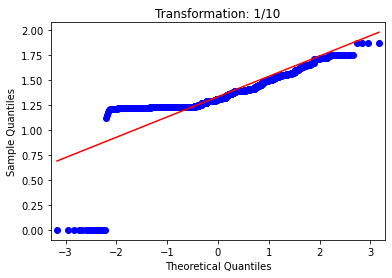

In [44]:
#Generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = train_test['Fare']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))
    
#We want blue lined up with red 
#Looks better around x = 5 or 6

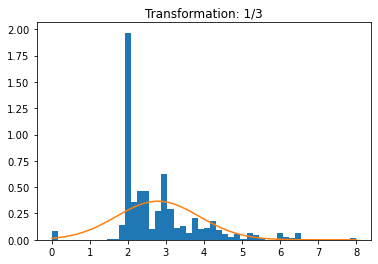

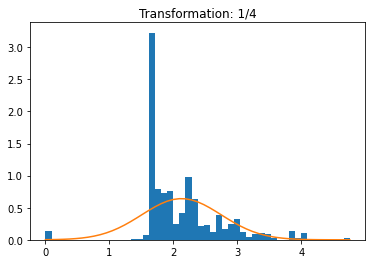

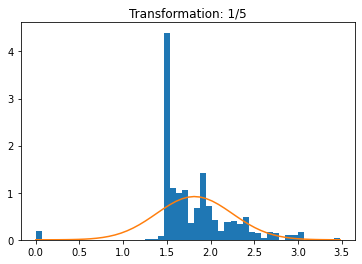

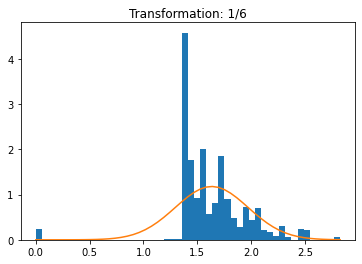

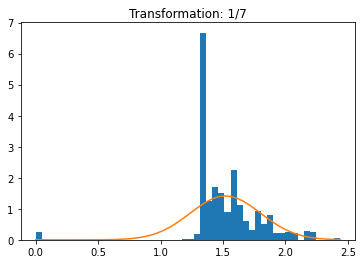

In [45]:
#Box-Cox transformation
for i in [3, 4, 5, 6, 7]:
    data_t = train_test['Fare']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()
    
#1/6 is the best

In [46]:
#Create the new transformed feature

#Call lambda function on existing feature and apply exponent 1/5 and store in our variable name
train_test['FareTransformed'] = train_test['Fare'].apply(lambda x: x**(1/6))
train_test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount,FareTransformed
0,1,0.0,3,1,22.0,7.2500,3,12,0,1,1.391200
1,2,1.0,1,0,38.0,71.2833,0,13,1,1,2.036251
2,3,1.0,3,0,26.0,7.9250,3,9,0,0,1.411995
3,4,1.0,1,0,35.0,53.1000,3,13,1,1,1.938723
4,5,0.0,3,1,35.0,8.0500,3,12,0,0,1.415683


In [47]:
train_test.drop(columns = 'Fare')

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Title,CabinMissing,FamCount,FareTransformed
0,1,0.0,3,1,22.0,3,12,0,1,1.391200
1,2,1.0,1,0,38.0,0,13,1,1,2.036251
2,3,1.0,3,0,26.0,3,9,0,0,1.411995
3,4,1.0,1,0,35.0,3,13,1,1,1.938723
4,5,0.0,3,1,35.0,3,12,0,0,1.415683
...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,28.0,3,12,0,0,1.415683
414,1306,NaN,1,0,39.0,0,3,1,0,2.185268
415,1307,NaN,3,1,38.5,3,12,0,0,1.391200
416,1308,NaN,3,1,28.0,3,12,0,0,1.415683


### Train and Test Split

In [50]:
#Split into train and test again

train_test

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount,FareTransformed
0,1,0.0,3,1,22.0,7.2500,3,12,0,1,1.391200
1,2,1.0,1,0,38.0,71.2833,0,13,1,1,2.036251
2,3,1.0,3,0,26.0,7.9250,3,9,0,0,1.411995
3,4,1.0,1,0,35.0,53.1000,3,13,1,1,1.938723
4,5,0.0,3,1,35.0,8.0500,3,12,0,0,1.415683
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,1,28.0,8.0500,3,12,0,0,1.415683
414,1306,NaN,1,0,39.0,108.9000,0,3,1,0,2.185268
415,1307,NaN,3,1,38.5,7.2500,3,12,0,0,1.391200
416,1308,NaN,3,1,28.0,8.0500,3,12,0,0,1.415683


In [51]:
train_clean = train_test[:891]
train_clean = train_clean.drop(columns = 'PassengerId')
train_clean

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount,FareTransformed
0,0.0,3,1,22.0,7.2500,3,12,0,1,1.391200
1,1.0,1,0,38.0,71.2833,0,13,1,1,2.036251
2,1.0,3,0,26.0,7.9250,3,9,0,0,1.411995
3,1.0,1,0,35.0,53.1000,3,13,1,1,1.938723
4,0.0,3,1,35.0,8.0500,3,12,0,0,1.415683
...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,27.0,13.0000,3,15,0,0,1.533406
887,1.0,1,0,19.0,30.0000,3,9,1,0,1.762734
888,0.0,3,0,27.0,23.4500,3,9,0,3,1.691832
889,1.0,1,1,26.0,30.0000,0,12,1,0,1.762734


In [52]:
train_clean.isna().sum()

Survived           0
Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
Title              0
CabinMissing       0
FamCount           0
FareTransformed    0
dtype: int64

In [53]:
test_clean = train_test[891:]
test_clean = test_clean.drop(columns = 'Survived')
test_clean

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,CabinMissing,FamCount,FareTransformed
0,892,3,1,34.5,7.8292,2,12,0,0,1.409136
1,893,3,0,47.0,7.0000,3,13,0,1,1.383088
2,894,2,1,62.0,9.6875,2,12,0,0,1.460053
3,895,3,1,27.0,8.6625,3,12,0,0,1.433091
4,896,3,0,22.0,12.2875,3,13,0,2,1.519068
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,28.0,8.0500,3,12,0,0,1.415683
414,1306,1,0,39.0,108.9000,0,3,1,0,2.185268
415,1307,3,1,38.5,7.2500,3,12,0,0,1.391200
416,1308,3,1,28.0,8.0500,3,12,0,0,1.415683


In [54]:
test_clean.isna().sum()

PassengerId        0
Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
Title              0
CabinMissing       0
FamCount           0
FareTransformed    0
dtype: int64

## Model Training

In [55]:
X_train = train_clean.drop("Survived", axis=1)
Y_train = train_clean["Survived"]
X_test  = test_clean.drop(columns = "PassengerId")
X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [56]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_)) #print best parameters

    means = results.cv_results_['mean_test_score'] #avg test score
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params)) #print each result for each param

In [57]:
#Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)], #number of individual trees
    'max_depth': [2, 4, 8, 16, 32, None] #max dept for each individual tree
}

cv = GridSearchCV(rf, parameters, cv=5) # cv = 5 for 5 fold cross validation
cv.fit(X_train, Y_train.values.ravel()) # we convert train_labels to array

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 128}

0.788 (+/-0.046) for {'max_depth': 2, 'n_estimators': 8}
0.782 (+/-0.052) for {'max_depth': 2, 'n_estimators': 16}
0.783 (+/-0.041) for {'max_depth': 2, 'n_estimators': 32}
0.78 (+/-0.047) for {'max_depth': 2, 'n_estimators': 64}
0.796 (+/-0.048) for {'max_depth': 2, 'n_estimators': 128}
0.781 (+/-0.044) for {'max_depth': 2, 'n_estimators': 256}
0.786 (+/-0.046) for {'max_depth': 2, 'n_estimators': 512}
0.824 (+/-0.048) for {'max_depth': 4, 'n_estimators': 8}
0.813 (+/-0.038) for {'max_depth': 4, 'n_estimators': 16}
0.82 (+/-0.026) for {'max_depth': 4, 'n_estimators': 32}
0.814 (+/-0.031) for {'max_depth': 4, 'n_estimators': 64}
0.82 (+/-0.036) for {'max_depth': 4, 'n_estimators': 128}
0.82 (+/-0.029) for {'max_depth': 4, 'n_estimators': 256}
0.817 (+/-0.034) for {'max_depth': 4, 'n_estimators': 512}
0.822 (+/-0.054) for {'max_depth': 8, 'n_estimators': 8}
0.827 (+/-0.06) for {'max_depth': 8, 'n_estimators': 16}
0.831 (+/-0.043) for {

In [58]:
random_forest = RandomForestClassifier(n_estimators=128)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

98.43

In [63]:
submission = pd.DataFrame({
        "PassengerId": test_clean["PassengerId"],
        "Survived": Y_pred
    })
submission['Survived'] = submission['Survived'].astype(int)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [64]:
submission.to_csv('submission.csv', index=False)

## Conclusion

After training and testing my Random Forest model, I have an accuracy score of 98.43 on the training set. When I run the model on the test set, I have an accuracy score of 80%, which is pretty good for a first model! 

Overall, I think that I utilized the best type of Machine Learning model for this project, but my model may be lacking certain features in regards to the exploratory data analysis section. With time and experience, I would hope to improve my EDA skills, to find more effective ways to determine which features should be utilized and which features should be feature engineered or dropped. In particular, I would hope to expand my knowledge in regards to dealing with NaN values.